In [1]:
#! pip install ultralytics 
#! pip install psycopg2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
#import psycopg2
import im_utils
#import db_ops
import pandas as pd

import cv2

import tensorflow as tf
print(tf.__version__)

from keras.models import Model
from keras.saving import load_model

from ultralytics import YOLO

from sklearn.metrics import confusion_matrix
from make_confusion_matrix import make_confusion_matrix

2.16.2


In [2]:
# Read the labels form the test dataset and 
# Convert them to the format that Nick used for the training dataset
# (lower case and underscore instead of spaces)

import os
import yaml

with open("../manual_test_dataset/data.yaml") as stream:
    try:
        test_lbls = yaml.safe_load(stream)['names']
    except yaml.YAMLError as exc:
        print(exc)

test_lbls = [x.lower().replace(' ', '_') for x in test_lbls]

In [3]:
# load dataframe that correlated predicted names, thier index and database ID
id_idx_df = pd.read_csv('brand_ids_idx.csv', sep = '\t')

In [4]:
# For the lables in the test that are not present in the train set, we assign 'unknown' label
test_lbls = [lbl if (lbl in id_idx_df['brand_name'].values) else 'unknown' for lbl in test_lbls]

In [5]:
# Get the df with ground truth boxes from test dataset 
label_path = '../manual_test_dataset/test/labels'
lbl_files = os.listdir(label_path)
file_names = []
labels = []
lst_cent_x = []
lst_cent_y = []
lst_box_w = []
lst_box_h = []

for file in lbl_files:
    file_name = file.split('_jpg')[0]
    with open(label_path + '/'+file, 'r') as label_file:
        for line in label_file:
            idx, cent_x, cent_y, box_w, box_h = line.split(' ')
            lst_cent_x.append(float(cent_x))
            lst_cent_y.append(float(cent_y))
            lst_box_w.append(float(box_w))
            lst_box_h.append(float(box_h))
            labels.append(test_lbls[int(idx)])
            file_names.append(file_name)
        
test_labels_df = pd.DataFrame({'im_name':file_names,
                               'true': labels,
                                'cent_x': lst_cent_x,
                                'cent_y': lst_cent_y,
                                'box_w': lst_box_w,
                                'box_h': lst_box_h}, index = range(len(file_names)))
test_labels_df['box_id'] = range(len(test_labels_df))

In [6]:
# Get the list of image files
image_path = '../manual_test_dataset/test/images'
files = os.listdir(image_path)
image_names = [file.split('_jpg')[0] for file in files]

In [7]:

# load image classification model
classifier = load_model("./models/B0_EffNet_classifier.keras")

# load logo detection model
detector = YOLO('./models/logo_detector.pt')


2024-07-28 02:57:30.866802: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-28 02:57:30.887171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-28 02:57:30.888208: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [ ]:
# Detection stage
boxes_df = pd.DataFrame(columns = ['im_name', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord', 'box_conf', 'predicted'])

for file in files:
    print('-'*30)
    try:
        # Scale the image and write to the local folder  
        image_original = cv2.imread(os.path.join(image_path, file))
        image_scaled = im_utils.ScaleImage(image_original, width = 640)
        
        # Run logo detector
        results = detector(image_scaled, conf = 0.1)
        
        # Find the saceling factor
        w_ratio = image_original.shape[1]/image_scaled.shape[1]
        h_ratio = image_original.shape[0]/image_scaled.shape[0]
        for i in range(len(results[0].boxes.xyxy)):   # Iterate over each box
            # Get the coordinates of the box on the original image
            xmin, ymin, xmax, ymax = map(int, results[0].boxes.xyxy[i]) 
            xmin = int(xmin * w_ratio)
            xmax = int(xmax * w_ratio)
            ymin = int(ymin * h_ratio)
            ymax = int(ymax * h_ratio)

            # Get the section of the original image that is in the box
            box_im = image_original[ymin:ymax, xmin:xmax,:]

            # Run the logo classifier on this box
            box_im = cv2.resize(box_im, (254,254))
            y_pred = classifier.predict(box_im.reshape(1,254,254,3))
            y_pred_dense = np.argmax(y_pred, axis=1)
            brand_name_df = id_idx_df[id_idx_df['idx'] == y_pred_dense[0]]
            
            # Save the box locally as an individual file
            idx = len(boxes_df)
            boxes_df.loc[idx, 'im_name'] = file.split('_jpg')[0]
            boxes_df.loc[idx, 'xmin_coord'] = xmin
            boxes_df.loc[idx, 'ymin_coord'] = ymin
            boxes_df.loc[idx, 'xmax_coord'] = xmax
            boxes_df.loc[idx, 'ymax_coord'] = ymax
            boxes_df.loc[idx, 'box_conf'] = float(results[0].boxes.conf[i])
            boxes_df.loc[idx, 'brand_conf'] = max(y_pred[0])
            boxes_df.loc[idx, 'predicted'] = brand_name_df['brand_name'].iloc[0]
    except Exception as e:
        print(e)

# Save predictions 
boxes_df.to_csv('EffNet_boxes_manual_01conf.csv', sep='\t', index=False)


In [9]:
# Read saved predictions to not re-run the prediction job
boxes_df_read = pd.read_csv('EffNet_boxes_manual_01conf.csv', sep='\t')
boxes_df_read['box_id'] = range(len(test_labels_df), len(test_labels_df) + len(boxes_df_read))
boxes_df_read['predicted'][boxes_df_read['predicted']=='zz_unbranded'] = 'unknown'

/tmp/ipykernel_2778/2210980906.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  boxes_df_read['predicted'][boxes_df_read['predicted']=='zz_unbranded'] = 'unknown'


In [11]:
def bb_iou(boxA, boxB):
	'''
	Caluclates the intersection over union between two bounding boxes
	'''
	# Make the field that covers both boxes
	y_max = max(boxA[3], boxB[3])
	x_max = max(boxA[2], boxB[2])
	field = np.zeros((y_max, x_max))

	#Make masks for the boxes
	maskA = field.copy()
	maskA[boxA[1]:boxA[3], boxA[0]:boxA[2]] = 1

	maskB = field.copy()
	maskB[boxB[1]:boxB[3], boxB[0]:boxB[2]] = 1

	#Use np logical functions to find IoU
	intersection = (np.logical_and(maskA, maskB)).sum()
	union = (np.logical_or(maskA, maskB)).sum()
	iou = intersection / float(union)

	return iou

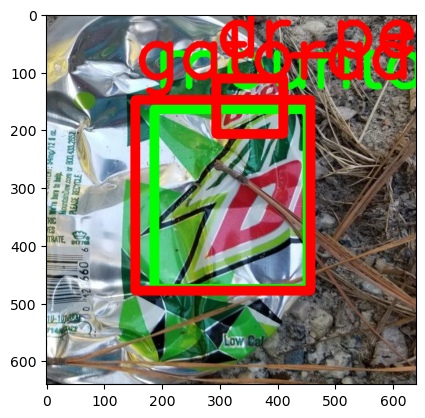

In [12]:
#Test cell to test boxes matching on one image

thr = 0.15
#im_file = 'IMG_6420_jpg.rf.7d5c73f52763c52e8df0e3cdb7acb41e.jpg'
#im_name  = im_file.split('_jpg')[0]

im_name = boxes_df_read['im_name'].iloc[0]
im_file = [file for file in os.listdir(image_path) if im_name in file][0]

# Get the data slices for this image
true_labels_df = test_labels_df[test_labels_df['im_name'] == im_name].copy()
pred_labels_df = boxes_df_read[boxes_df_read['im_name']==im_name].copy()

# Convert the YOLO notation to coordinates
# Get the dimentions of the original image
file_path = os.path.join(image_path, im_file)
im_orig = cv2.imread(file_path)
im_h, im_w = im_orig.shape[:2]
# Recalculate coordinates
true_labels_df['xmin_coord'] = (im_w * true_labels_df['cent_x'] - 0.5*im_w*true_labels_df['box_w']).astype(int)
true_labels_df['xmax_coord'] = (im_w * true_labels_df['cent_x'] + 0.5*im_w*true_labels_df['box_w']).astype(int)
true_labels_df['ymin_coord'] = (im_h * true_labels_df['cent_y'] - 0.5*im_h*true_labels_df['box_h']).astype(int)
true_labels_df['ymax_coord'] = (im_h * true_labels_df['cent_y'] + 0.5*im_h*true_labels_df['box_h']).astype(int)

# Go over each true lable in this image
for i in range(len(true_labels_df)): 
	dict_IoU = {-1:-1} # make a dict of pred_box_id:IoU pairs for this true box
	# Construct a box for the true box
	boxA = true_labels_df['xmin_coord'].iloc[i], true_labels_df['ymin_coord'].iloc[i], \
		true_labels_df['xmax_coord'].iloc[i], true_labels_df['ymax_coord'].iloc[i] 

	# Go over every predicted box
	for j in range(len(pred_labels_df)): # calculate IoU between true and predicted box
		boxB = pred_labels_df['xmin_coord'].iloc[j], pred_labels_df['ymin_coord'].iloc[j],\
			pred_labels_df['xmax_coord'].iloc[j], pred_labels_df['ymax_coord'].iloc[j] 
		dict_IoU[pred_labels_df['box_id'].iloc[j]] = bb_iou(boxA, boxB)

	# Find the ID of the box that overlaps the most
	max_box_id = max(dict_IoU, key=dict_IoU.get)
	# If its IoU is above threshold
	# update the box ID of predicted box to match ID of the true box
	if dict_IoU[max_box_id] > thr:
		idx = pred_labels_df[pred_labels_df['box_id'] == max_box_id].index
		pred_labels_df.at[idx[0], 'box_id'] =  true_labels_df['box_id'].iloc[i]

# Collect both true and predicted boxes in the image
image_boxes_df = pd.merge(true_labels_df, pred_labels_df, on='box_id', how='outer')

# Make a column with image name, given that pred or true can be empty
image_boxes_df['im_name'] = image_boxes_df['im_name_x'].fillna(image_boxes_df['im_name_y'])

# Calcualte total confidence for the predictions
# No precitions is the same as predicting background, 
# mAP does not include it background, so put 1, whatever
image_boxes_df['conf'] = image_boxes_df['box_conf'] * image_boxes_df['brand_conf']
image_boxes_df['conf'] = image_boxes_df['conf'].fillna(1)

# No label means background
image_boxes_df[['predicted', 'true']] = image_boxes_df[['predicted', 'true']].fillna('background')

# Get only the columns we need
image_boxes_df = image_boxes_df[['im_name', 'conf', 'predicted', 'true', 'box_id']]

# Draw ground truth boxes:
# for each box, draw the box and label
for box_params in true_labels_df[['true', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord']].values:
	lbl, x1, y1, x2, y2 = box_params
	color = (0,255,0)
	cv2.rectangle(im_orig, (x1,y1), (x2,y2), color, 15)
	cv2.putText(im_orig, lbl, (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 4, color, 10, cv2.LINE_AA)

# Draw predicted boxes 
for box_params in pred_labels_df[['predicted', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord']].values:
	lbl, x1, y1, x2, y2 = box_params
	color = (0,0,255)
	cv2.rectangle(im_orig, (x1,y1), (x2,y2), color, 15)
	cv2.putText(im_orig, lbl, (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 4, color, 10, cv2.LINE_AA)

#Show the picture
plt.imshow(cv2.cvtColor(im_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
image_boxes_df

,im_name,conf,predicted,true,box_id
0,2022_09_23_XmGzihubOxzEzCYD8OytdpGxx0YbVxERUpr...,0.475258,gatorade,mountain_dew,625
1,2022_09_23_XmGzihubOxzEzCYD8OytdpGxx0YbVxERUpr...,0.758134,dr_pepper,background,809


In [14]:
# Go over the dataset and corrrelate bounding boxes from ground truth and predictions
thr = 0.15
boxes_df = pd.DataFrame(columns = ['im_name', 'conf', 'predicted', 'true', 'box_id'])
for im_file in os.listdir(image_path):
	print('---', im_file, '---')
	im_name  = im_file.split('_jpg')[0]

	# Get the data slices for this image
	true_labels_df = test_labels_df[test_labels_df['im_name'] == im_name].copy()
	pred_labels_df = boxes_df_read[boxes_df_read['im_name']==im_name].copy()

	# Convert the YOLO notation to coordinates
	# Get the dimentions of the original image
	file_path = os.path.join(image_path, im_file)
	im_orig = cv2.imread(file_path)
	im_h, im_w = im_orig.shape[:2]
	# Recalculate coordinates
	true_labels_df['xmin_coord'] = (im_w * true_labels_df['cent_x'] - 0.5*im_w*true_labels_df['box_w']).astype(int)
	true_labels_df['xmax_coord'] = (im_w * true_labels_df['cent_x'] + 0.5*im_w*true_labels_df['box_w']).astype(int)
	true_labels_df['ymin_coord'] = (im_h * true_labels_df['cent_y'] - 0.5*im_h*true_labels_df['box_h']).astype(int)
	true_labels_df['ymax_coord'] = (im_h * true_labels_df['cent_y'] + 0.5*im_h*true_labels_df['box_h']).astype(int)

	# Go over each true lable in this image
	for i in range(len(true_labels_df)): 
		dict_IoU = {-1:-1} # make a dict of pred_box_id:IoU pairs for this true box
		# Construct a box for the true box
		boxA = true_labels_df['xmin_coord'].iloc[i], true_labels_df['ymin_coord'].iloc[i], \
			true_labels_df['xmax_coord'].iloc[i], true_labels_df['ymax_coord'].iloc[i] 

		# Go over every predicted box
		for j in range(len(pred_labels_df)): # calculate IoU between true and predicted box
			boxB = pred_labels_df['xmin_coord'].iloc[j], pred_labels_df['ymin_coord'].iloc[j],\
				pred_labels_df['xmax_coord'].iloc[j], pred_labels_df['ymax_coord'].iloc[j] 
			dict_IoU[pred_labels_df['box_id'].iloc[j]] = bb_iou(boxA, boxB)

		# Find the ID of the box that overlaps the most
		max_box_id = max(dict_IoU, key=dict_IoU.get)
		# If its IoU is above threshold
		# update the box ID of predicted box to match ID of the true box
		if dict_IoU[max_box_id] > thr:
			idx = pred_labels_df[pred_labels_df['box_id'] == max_box_id].index
			pred_labels_df.at[idx[0], 'box_id'] =  true_labels_df['box_id'].iloc[i]

	# Collect both true and predicted boxes in the image
	image_boxes_df = pd.merge(true_labels_df, pred_labels_df, on='box_id', how='outer')

	# Make a column with image name, given that pred or true can be empty
	image_boxes_df['im_name'] = image_boxes_df['im_name_x'].fillna(image_boxes_df['im_name_y'])

	# Calcualte total confidence for the predictions
	# No precitions is the same as predicting background, 
	# mAP does not include it background, so put 1, whatever
	image_boxes_df['conf'] = image_boxes_df['box_conf'] * image_boxes_df['brand_conf']
	image_boxes_df['conf'] = image_boxes_df['conf'].astype(float).fillna(1.0)

	# No label means background
	image_boxes_df[['predicted', 'true']] = image_boxes_df[['predicted', 'true']].fillna('background')

	# Get only the columns we need
	image_boxes_df = image_boxes_df[['im_name', 'conf', 'predicted', 'true', 'box_id']]
	boxes_df = pd.concat([boxes_df,image_boxes_df],ignore_index=True)
boxes_df.head(3)

--- 2022_09_23_XmGzihubOxzEzCYD8OytdpGxx0YbVxERUprftx40_jpg.rf.7dac433ecb592ed65b3c887ae3a596fb.jpg ---
--- 2022_02_27_1FLq9Fp43ySh2CmRN89VxWxijz5NiTbTtl7oSIPg_jpg.rf.c29a43a7ba832d798fa641b287b69a18.jpg ---
--- 2022_10_01_ynt1C9X6vIbSEk34pr9md8yj6wfnIAwP0tvjQq3m_jpg.rf.7c528f3197dcba1c1a49237fbd209626.jpg ---
--- 2022_03_29_sYNyqu1klWQ2nGhV5PZnDz3eZd8HeOMSabPBTNV5_jpg.rf.2f62644bc76ce8c02aae31d94154af5a.jpg ---
--- 2022_02_15_UNTVpd1TLZNYnu0BNSNZppw9NPpd0xFZEBjdjK6B_jpg.rf.b920caaf1407f1ae5b34066566962198.jpg ---
--- IMG_6555_jpg.rf.77d215015cd25df84386f9d27cfe7d78.jpg ---
--- wq0pYiz5ygdinqyRqmlGLQ6VeP07JPvZel1ny97F_jpg.rf.120ce2550b169250f051d438a947a0d3.jpg ---
--- 2021_07_18_DwmAOI5WeZpLtnJPGLN4QMS6KHOZJeO52g0b8kxO_jpg.rf.f7a64f752055c02c8b5c8d6868f4a88a.jpg ---
--- 2020_08_28_da6eBEyUHwnfTeq94ZBqKGVSVbY1kWyVrBxp0vLk_jpg.rf.a9b3ddbd79542739c18e94e329d79e90.jpg ---
--- 2022_02_24_APvQv92pBfnjuhfUyKZoYC2DjghNk3EohkWNMJ9A_jpg.rf.27dd413a7aa2956a6799f1fafb0e85b4.jpg ---
--- 2019_06_11

/tmp/ipykernel_2778/993062987.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  boxes_df = pd.concat([boxes_df,image_boxes_df],ignore_index=True)


--- 2022_02_20_J21MggCi3kYLyJUekvvIxahkAM32TeUSpMp7ntjE_jpg.rf.609c9430f71e10a7acefcae0f3f59b55.jpg ---
--- 2022_07_01_zR5Eum1nKQ2smDb5pCaPXdsjVy2MXWr9mWW2haMM_jpg.rf.6e065804c96e78dbb6b582229ce5a016.jpg ---
--- 2018_09_13_xOkZ1jG0K3VGClsEKpFuAuAxda9mZYbGDqYWee5B_jpg.rf.c1e3c4bdecf5f17c2a9a1c8f02f79c74.jpg ---
--- 2021_08_01_qKvKJ2cnBCcRXgcygLY6dWmdCwmbUGbGF28GXRff_jpg.rf.c43045152879415d134af07c5fcef3e8.jpg ---
--- 2022_01_14_r5FbF4CEARs6xTrIWe5gGjfGaKqnCTxBTBQ3DhG1_jpg.rf.04b8f156a9b60d5c92e4ca30038fb28e.jpg ---
--- 2021_04_16_IMG_1549_jpg.rf.0c69bdfd282ea68bad1e3380ac97b61b.jpg ---
--- 2022_01_17_SFEQr1n1XsC33cohvvzTYG9In1IKQcMfwWqjnJkG_jpg.rf.c45b31089eae5a25142148ce99dccede.jpg ---
--- 2021_10_06_7PhddMBNvgvEyOfHws73yZiNwalH5odp8YyHkOmK_jpg.rf.db3b10b8e46e825b281f7a4aea6b53a0.jpg ---
--- 2021_12_24_IezMybAQ9KD43PCzivdDZmHNiZxGErCOL4AHb0ia_jpg.rf.08e77c241d8aca2bf622043d93801cb6.jpg ---
--- 2022_07_26_BnCIz5FgwWtPcMXZsp8uLT4QLFv1GT2IgOiznYER_jpg.rf.25f576bee4375fd4d0d8ed42adbd5593.

,im_name,conf,predicted,true,box_id
0,2022_09_23_XmGzihubOxzEzCYD8OytdpGxx0YbVxERUpr...,0.475258,gatorade,mountain_dew,625
1,2022_09_23_XmGzihubOxzEzCYD8OytdpGxx0YbVxERUpr...,0.758134,dr_pepper,background,809
2,2022_02_27_1FLq9Fp43ySh2CmRN89VxWxijz5NiTbTtl7...,0.665462,amstel_light,amstel_light,10


In [15]:
def isTP(row, brand):
    if (row['true'] == brand) & (row['predicted'] == brand):
        return 1
    else:
        return 0
    
def isFP(row, brand):
    if (row['true'] != brand) & (row['predicted'] == brand):
        return 1
    else:
        return 0

In [16]:
# Calcualte mAP for this threshold
APs = {}

# Get the number of boxes per each label in the test set
test_lbl_count = test_labels_df.groupby('true')['im_name'].count().sort_values(ascending=False)

# Evaluate AP for every brand that is in the test set
# We do not evaluate precision for brands that are not in test set,
#  these are hallucianations and precision is not defined for them.
for brand in test_lbls:
    # Select only boxes pertaining to this brand
    brand_df = boxes_df[boxes_df['predicted'].str.contains(brand, case=False) | 
                            boxes_df['true'].str.contains(brand, case=False)].copy()
    # Figure out if each box is TP or FP, do not care for FN or TN
    brand_df['FP'] = brand_df.apply(lambda x: isFP(x, brand), axis=1)
    brand_df['TP'] = brand_df.apply(lambda x: isTP(x, brand), axis=1)

    # Sort the boxes by confidence
    brand_df.sort_values('conf', ascending=False, inplace=True)
    brand_df.reset_index(drop=True, inplace=True)

    # Figure out which record is TP and which is FP
    # We do not care for FN and TN for mAP metric
    # Then compute precision and recall for every level of confidence
    rec_lvls = np.linspace(0, 1, 11)
    for i in range(len(brand_df)):
        TP = brand_df.loc[:i, 'TP'].sum()
        FP = brand_df.loc[:i, 'FP'].sum()
        try:
            count = test_lbl_count[brand]
        except KeyError:
            count = 0
        if (TP+FP) >0:
            brand_df.loc[i, 'prec'] = TP/float(TP+FP)
        else:
            brand_df.loc[i, 'prec'] = 0
        brand_df.loc[i, 'rec'] = TP/float(count)

    # Compute AP using COCO 11-Point Interpolation:
    # take 11 evenly spaced recall levels
    # compute area under Prec-Rec curve interpolated at these levels.
    prec_rec_df = pd.DataFrame(columns = ['rec', 'prec'])
    for i, lvl in enumerate(rec_lvls):
        if len(brand_df[brand_df['rec']>= lvl]['prec'])>0:
            max_prec = brand_df[brand_df['rec']>= lvl]['prec'].max()
        else:
            max_prec = 0
        prec_rec_df.loc[i] = [lvl, max_prec]
    prec_rec_df.fillna(0.0, inplace=True)
    AP = prec_rec_df['prec'].mean()
    APs[brand] = AP


mAP = np.mean(list(APs.values()))
mAP

0.2509931228320383

In [17]:
boxes_df

,im_name,conf,predicted,true,box_id
0,2022_09_23_XmGzihubOxzEzCYD8OytdpGxx0YbVxERUpr...,0.475258,gatorade,mountain_dew,625
1,2022_09_23_XmGzihubOxzEzCYD8OytdpGxx0YbVxERUpr...,0.758134,dr_pepper,background,809
2,2022_02_27_1FLq9Fp43ySh2CmRN89VxWxijz5NiTbTtl7...,0.665462,amstel_light,amstel_light,10
3,2022_02_27_1FLq9Fp43ySh2CmRN89VxWxijz5NiTbTtl7...,0.589888,amstel_light,amstel_light,11
4,2022_02_27_1FLq9Fp43ySh2CmRN89VxWxijz5NiTbTtl7...,0.077000,amstel_light,background,813
...,...,...,...,...,...
1177,2021_12_16_cTJnOwsI10M89EKq966bidVqZzS9BhgdZwG...,0.049604,guinness,background,1696
1178,2020_02_01_UMMTbuMWbCcz97loDwZzVTrzqHE7pG0DIvQ...,0.325149,unknown,cheetos,43
1179,2020_02_01_UMMTbuMWbCcz97loDwZzVTrzqHE7pG0DIvQ...,0.395098,unknown,background,1698
1180,2021_06_05_IMG_0565,0.397058,heineken,powerade,409


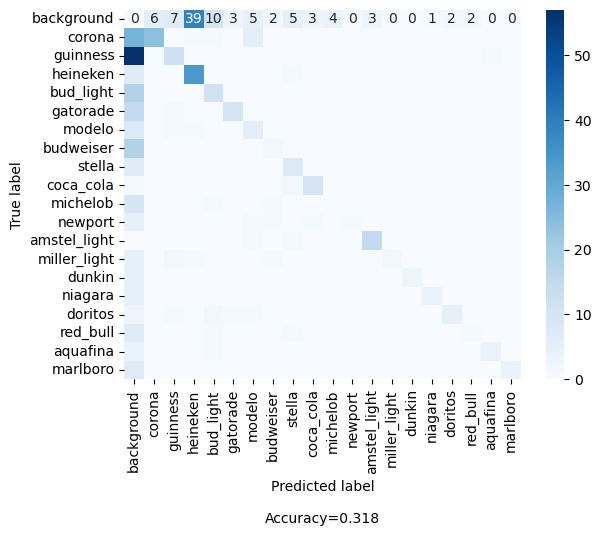

In [18]:
cf_matrix_df = boxes_df.copy()
test_lbl_count = boxes_df.groupby('true')['im_name'].count().sort_values(ascending=False)
cf_matrix_df['counts'] = cf_matrix_df['true'].apply(lambda x: test_lbl_count[x] )
cf_matrix_df.sort_values('counts', ascending=False, inplace=True)
sorted_dict = sorted(test_lbl_count.items(), key=lambda x: x[1], reverse=True)
labels = [item[0] for item in sorted_dict][:20]
cf_matrix = confusion_matrix(y_true = boxes_df['true'], y_pred = boxes_df['predicted'], labels = labels)

make_confusion_matrix(cf_matrix, categories = labels, count = True, percent= False, cmap='Blues')